# Legacy Zeropoints vs. Obsdb

In [59]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import fitsio
from glob import glob
import os
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from scipy.stats import sigmaclip
from photutils import (CircularAperture, CircularAnnulus,
                               aperture_photometry, daofind)

from astrometry.util.fits import fits_table, merge_tables

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from obiwan.common import fits2pandas

from legacyzpts.qa.compare_idlzpts import ZptResiduals, StarResiduals
from legacyzpts.fetch import fetch_targz

# legacyzpts/test/test_compare_legacy_idl.py

In [58]:
from legacyzpts.test.test_compare_legacy_idl \
    import test_zpts_decam,test_stars_decam

In [5]:
zpt= test_zpts_decam(plot=False)
star= test_stars_decam(plot=False)

test_zpts_decam
Already exists: /home/kaylan/myrepo/legacyzpts/py/legacyzpts/test/testdata/idl_legacy_data.tar.gz
Merged zpt data: zpts=183
Merged zpt data: zpts=180
Wrote /home/kaylan/myrepo/legacyzpts/py/legacyzpts/test/testoutput_shared/expnum2exptime.json
Wrote /home/kaylan/myrepo/legacyzpts/py/legacyzpts/test/testoutput_shared/expnum2gain.json
test_stars_decam
Already exists: /home/kaylan/myrepo/legacyzpts/py/legacyzpts/test/testdata/idl_legacy_data.tar.gz
Merged zpt data: zpts=13278
Merged zpt data: zpts=13354
Read /home/kaylan/myrepo/legacyzpts/py/legacyzpts/test/testoutput_shared/expnum2exptime.json
Read /home/kaylan/myrepo/legacyzpts/py/legacyzpts/test/testoutput_shared/expnum2gain.json


In [7]:
zpt.legacy.data.columns

<bound method tabledata.columns of <tabledata object with 180 rows and 43 columns: crpix1, crpix2, seeing, ccdraoff, cd2_1, ccdzpt, cd2_2, propid, fwhm, naxis1, naxis2, zpt, filename, ccdra, ccdnmatch, ra, ccdrarms, ccdtransp, dec, airmass, crval2, crval1, ccdname, ccdphoff, object, ccdskyrms, ccddecrms, avsky, cd1_1, ccddec, expnum, ha, exptime, cd1_2, date_obs, ccddecoff, ut, filter, ccdskycounts, ccdskymag, ccdnum, ccdphrms, mjd_obs>>

In [13]:
star.legacy.data.columns

<bound method tabledata.columns of <tabledata object with 12856 rows and 20 columns: raoff, ccd_y, ccd_sky, magoff, image_hdu, ccd_x, filename, ccd_mag, decoff, ccd_ra, gmag, expnum, nmatch, ccd_dec, ps1_g, ps1_i, extname, filter, ps1_r, ps1_z>>

In [8]:
zpt.legacy.data.ccdphoff[:10]

array([-0.17165466, -0.19786575, -0.16340698, -0.19948733, -0.05585163,
       -0.19300875, -0.08995221, -0.11424308, -0.15971962, -0.13884135], dtype=float32)

In [9]:
zpt.idl.data.ccdphoff[:10]

array([ 0.02200323, -0.00546677,  0.0927227 ,  0.07831062,  0.01621491,
        0.05363761, -0.01175174,  0.01048197,  0.03751214,  0.04611161], dtype=float32)

In [14]:
star.legacy.data.magoff[:10]

array([ 0.0170517 ,  0.03237915,  0.22123909,  0.02169037,  0.02754211,
        0.01263428, -0.0428009 ,  0.00880814,  0.02700996,  0.01550484], dtype=float32)

In [15]:
star.idl.data.magoff[:10]

array([ 0.01794766,  0.03239455,  0.22445528,  0.02185543,  0.02787409,
        0.01561843, -0.0050574 ,  0.01482865,  0.0385462 ,  0.0181986 ], dtype=float32)

### There is a 10 mmag offset between idl and legacy for the median ps1 apmag difference

-0.102841


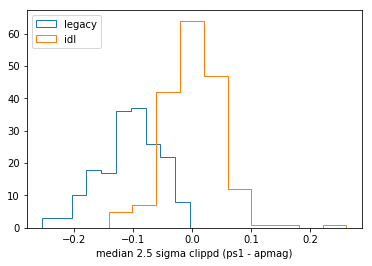

In [31]:
_=plt.hist(zpt.legacy.data.ccdphoff,label='legacy',
           histtype='step')
_=plt.hist(zpt.idl.data.ccdphoff,label='idl',
           histtype='step')
plt.legend()
plt.xlabel('median 2.5 sigma clippd (ps1 - apmag)')
print(np.median(zpt.legacy.data.ccdphoff))

#### Is this in the -zpt.fits file?

In [52]:
raw_dir= "/home/kaylan/myrepo/legacyzpts/py/legacyzpts/test"
raw= fits_table(os.path.join(raw_dir,
        'testoutput_zpts/temptable_decam_legacy.fits'))

-0.10284059

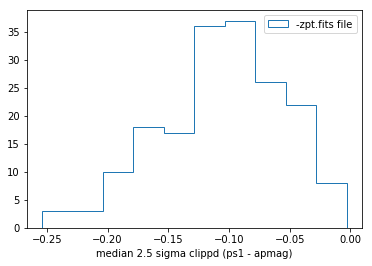

In [53]:
_=plt.hist(raw.phoff,label='-zpt.fits file',
           histtype='step')
plt.legend()
plt.xlabel('median 2.5 sigma clippd (ps1 - apmag)')
np.median(raw.phoff)

### But how can the median phoff exist when we don't see it in that stars table?? it must be due to units or something between idl and legacy b/c both legacy and idl have good ps1 - apmag distribution for all stars

-0.0156708


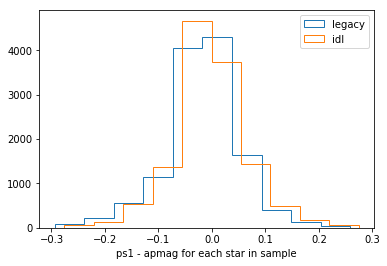

In [35]:
legacy_magoff, _, _ = sigmaclip(star.legacy.data.magoff)
idl_magoff, _, _ = sigmaclip(star.idl.data.magoff)

_=plt.hist(legacy_magoff,label='legacy',
           histtype='step')
_=plt.hist(idl_magoff,label='idl',
           histtype='step')
plt.legend()
plt.xlabel('ps1 - apmag for each star in sample')
print(np.median(legacy_magoff))

In [54]:
raw_star= fits_table(os.path.join(raw_dir,
        'testoutput_stars/temptable_decam_legacy.fits'))

In [55]:
raw_star.columns

<bound method tabledata.columns of <tabledata object with 13354 rows and 31 columns: expid, daofind_y, daofind_x, amplifier, decdiff_ps1, image_filename, radiff_ps1, image_hdu, radiff, ps1_mag, apmag, ra, gaia_dec, mycuts_x, apflux, mycuts_y, gaia_ra, expnum, nmatch, decdiff, ps1_g, ps1_gicolor, gaia_g, filter, ps1_r, ps1_i, y, x, ps1_z, dec, apskyflux>>

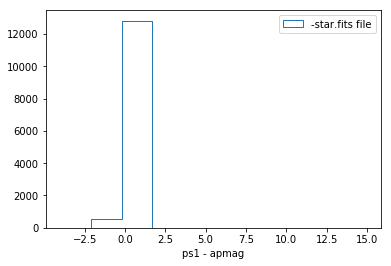

In [56]:
_=plt.hist(raw_star.ps1_mag - raw_star.apmag,label='-star.fits file',
           histtype='step')
plt.legend()
plt.xlabel('ps1 - apmag')
#np.median(raw_star.phoff)

-0.00299448


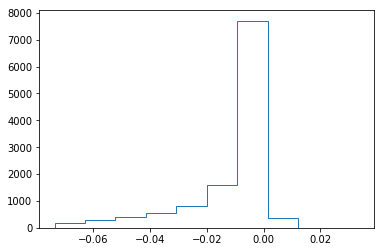

In [26]:
diff,_,_= sigmaclip(star.legacy.data.magoff - star.idl.data.magoff)
_=plt.hist(diff,histtype='step')
print(np.median(diff))

# CCD_RA and DEC

count    1.284700e+04
mean    -2.016600e-10
std      3.994875e-09
min     -1.047965e-08
25%     -2.529120e-09
50%     -2.513900e-10
75%      2.182944e-09
max      9.456443e-09
Name: diff_ra, dtype: float64


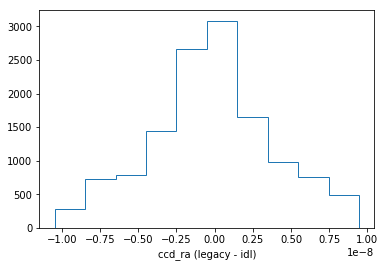

In [65]:
diff_ra,_,_= sigmaclip(star.legacy.data.ccd_ra - star.idl.data.ccd_ra)
df= pd.DataFrame({'diff_ra':diff_ra})
_=plt.hist(df['diff_ra'],
           histtype='step')
plt.xlabel('ccd_ra (legacy - idl)')
print(df['diff_ra'].describe())

count    1.284700e+04
mean    -1.606490e-13
std      1.931066e-09
min     -5.095851e-09
25%     -1.126941e-09
50%      8.618883e-12
75%      1.133754e-09
max      5.259755e-09
Name: diff_dec, dtype: float64


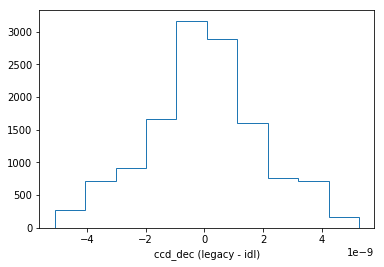

In [66]:
diff_dec,_,_= sigmaclip(star.legacy.data.ccd_dec - star.idl.data.ccd_dec)
df['diff_dec']= diff_dec
_=plt.hist(df['diff_dec'],
           histtype='step')
plt.xlabel('ccd_dec (legacy - idl)')
print(df['diff_dec'].describe())